

Prepare the MNIST data set for training by normalizing the pixel values and reshaping the images to have a single color channel. Normalization helps in faster convergence during training, and reshaping is required because the input layer of the diffusion model expects a three-dimensional tensor.


- Use Keras to load the MNIST data set. <br/>
- Normalize the image pixel values to the range [0, 1]. <br/>
- Expand the dimensions of the images to match the input shape required by the model (28x28x1).


In [1]:
# %%capture
# !pip install tensorflow-cpu==2.16.2

import os
# Suppress oneDNN optimizations and lower TensorFlow logging level
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [2]:
# !pip install numpy

In [3]:
# !pip install matplotlib

In [5]:
import keras
import tensorflow as tf
print(f"Keras version: {keras.__version__}")
print(f"TensorFlow version: {tf.__version__}")

Keras version: 3.6.0
TensorFlow version: 2.17.1


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Load the data set
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize the pixel values
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Expand dimensions to match the input shape (28, 28, 1)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Add noise to the data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to be within the range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


ImportError: cannot import name 'clip_to_image_size' from 'keras.src.layers.preprocessing.image_preprocessing.bounding_boxes.converters' (C:\Users\Chris\anaconda3\envs\hulk_1054_env\Lib\site-packages\keras\src\layers\preprocessing\image_preprocessing\bounding_boxes\converters.py)

Build the diffusion model <br/>

Build a simple diffusion model with an encoder that compresses the input image into a latent representation and a decoder that reconstructs the image from this representation. The model is compiled with the Adam optimizer and binary cross-entropy loss.

**1. Define the encoder:**
- Create an input layer with the shape (28, 28, 1).
- Add two Conv2D layers with increasing filter sizes and ReLU activation.

**2. Define the bottleneck:**
- Add a flattened layer followed by a dense layer with ReLU activation.

**3. Define the decoder:**
- Add a Dense layer to expand the bottleneck representation.
- Reshape the output to match the original image dimensions.
- Add two Conv2DTranspose layers with decreasing filter sizes and ReLU activation.
  
**4. Compile the model:**
- Use the Adam optimizer and binary cross-entropy loss.


In [5]:
# Define the diffusion model architecture with reduced complexity
input_layer = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)  # Reduced filters
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
x = Flatten()(x)
x = Dense(64, activation='relu')(x)  # Reduced size
x = Dense(28*28*32, activation='relu')(x)  # Reduced size
x = Reshape((28, 28, 32))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
diffusion_model = Model(input_layer, output_layer)

# Compile the model with mixed precision and a different loss function
diffusion_model.compile(optimizer='adam', loss='mean_squared_error')  # Using MSE for regression tasks

# Summary of the optimized model
diffusion_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25088)          │     1,630,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,255,233 (12.42 MB)

 Trainable params: 3,255,233 (12.42 MB)

 Non-trainable params: 0 (0.00 B)



Add random noise to the data set to simulate the diffusion process:
- Add Gaussian noise to the training and test data sets.
- Clip the values to ensure they remain within the valid range [0, 1].


In [6]:
# Cache and prefetch the data using TensorFlow data pipelines for faster loading
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_noisy, x_train))
train_dataset = train_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size

val_dataset = tf.data.Dataset.from_tensor_slices((x_test_noisy, x_test))
val_dataset = val_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size


Train the diffusion model to denoise the MINIST images. Use the noisy images as input and the original images as the target, learning to reverse the noise addition process.
- Use the ‘fit’ method to train the model on the noisy training data.
- Set the number of epochs to 50 and the batch size to 128.


In [7]:
# Implement early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with early stopping and smaller batch size
diffusion_model.fit(
    train_dataset,
    epochs=3,
    shuffle=True,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 318s 336ms/step - loss: 0.0658 - val_loss: 0.0288
Epoch 2/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 334s 356ms/step - loss: 0.0243 - val_loss: 0.0234
Epoch 3/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 383s 357ms/step - loss: 0.0209 - val_loss: 0.0208




Evaluate the performance of the trained diffusion model by predicting the denoised images and visualizing the results. Comparing the original, noisy, and denoised images will help you understand how well the model has learned to remove noise from the images.

**1. Reconstruct images:**
- Use the diffusion model to predict the denoised test images.  
- Compare the original, noisy, and denoised images.

**2. Visualize the results:**
- Plot a few examples of original, noisy, and denoised images side by side.


313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step


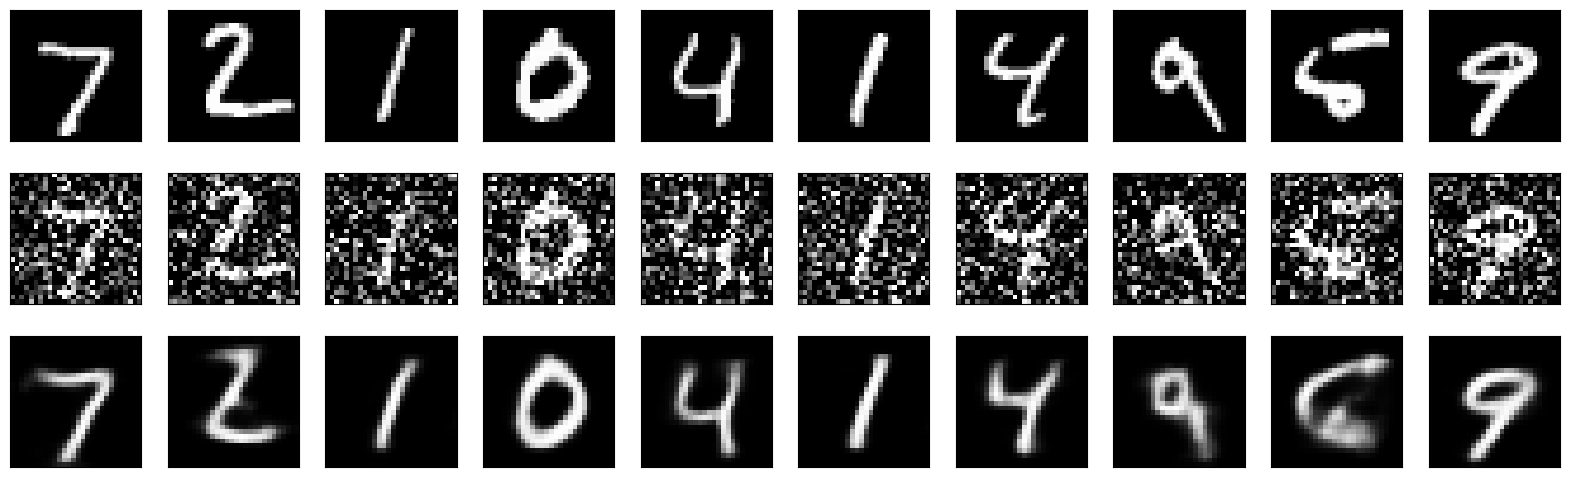

In [8]:
import matplotlib.pyplot as plt

# Predict the denoised images
denoised_images = diffusion_model.predict(x_test_noisy)

# Visualize the results
n = 10  # Number of digits to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()



Fine-tune the diffusion model by unfreezing some layers and retraining the model to improve its performance.


**1. Freeze the model layers:**
- Freeze all the layers of the encoder.

**2. Check the Status:**
- Checking the trainable status of each layer.

**3. Unfreeze the model layers:**
- Unfreeze the last few layers of the model to allow them to be retrained.

**4. Compile and train the model:**
- Recompile the model.
- Train the model again for an additional 10 epochs.


In [9]:
# Freeze all the layers
for layer in diffusion_model.layers:
    layer.trainable = False

In [10]:
# Check trainable status of each layer
for i, layer in enumerate(diffusion_model.layers):
    print(f"Layer {i}: {layer.name} — Trainable: {layer.trainable}")

Layer 0: input_layer — Trainable: False
Layer 1: conv2d — Trainable: False
Layer 2: conv2d_1 — Trainable: False
Layer 3: flatten — Trainable: False
Layer 4: dense — Trainable: False
Layer 5: dense_1 — Trainable: False
Layer 6: reshape — Trainable: False
Layer 7: conv2d_transpose — Trainable: False
Layer 8: conv2d_transpose_1 — Trainable: False
Layer 9: conv2d_2 — Trainable: False


In [11]:
# Unfreeze the top layers of the model
for layer in diffusion_model.layers[-4:]:
    layer.trainable = True

# Compile the model again
diffusion_model.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model again
diffusion_model.fit(x_train_noisy, x_train,
                    epochs=10,
                    batch_size=64,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test))


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 228s 241ms/step - loss: 0.1197 - val_loss: 0.1188
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 260s 240ms/step - loss: 0.1180 - val_loss: 0.1185
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 263s 241ms/step - loss: 0.1177 - val_loss: 0.1188
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 226s 241ms/step - loss: 0.1178 - val_loss: 0.1181
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 258s 237ms/step - loss: 0.1174 - val_loss: 0.1183
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 263s 238ms/step - loss: 0.1174 - val_loss: 0.1179
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 262s 238ms/step - loss: 0.1171 - val_loss: 0.1180
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 221s 236ms/step - loss: 0.1171 - val_loss: 0.1177
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 262s 236ms/step - loss: 0.1171 - val_loss: 0.1179
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 215s 229ms/step - loss: 0.1168 - val_loss: 0.1177


Modify the noise factor

1. Change the noise factor and see how it affects the model’s ability to denoise images.<br/>
2. Change the noise factor to 0.3.
3. Add noise to the training and test data sets with the new noise factor.
4. Retrain the model with the new noisy data.


In [ ]:
# Modify the noise factor to 0.3
noise_factor = 0.3

# Add noise to the data with the new noise factor
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to be within the range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
# Corrected the assignment for x_test_noisy clipping
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Retrain the model
# Changed the input data for training from x_test_noisy to x_train_noisy
diffusion_model.fit(x_train_noisy, x_train,
                    epochs=50,
                    batch_size=120,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test))

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 218s 436ms/step - loss: 0.1103 - val_loss: 0.1090
Epoch 2/50
297/500 ━━━━━━━━━━━━━━━━━━━━ 1:15 374ms/step - loss: 0.1099

Add more layers to the model   
1. Experiment with adding more layers to the model to see how it affects performance.
2. Add an additional Conv2D layer with 128 filters in the encoder.
3. Add an additional Conv2DTranspose layer with 128 filters in the decoder.
4. Rebuild, compile, and train the model.


In [ ]:
# Rebuild the model with additional layers
input_layer = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# Additional encoder layer
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
# Adjust Dense layer size based on the new flattened size (28*28*128)
# Calculate the new flattened size. Output shape after the last Conv2D layer (128 filters, padding='same') is (28, 28, 128)
flattened_size = 28 * 28 * 128
x = Dense(flattened_size // 4, activation='relu')(x) # Reduced size but adjust for new input
x = Dense(flattened_size, activation='relu')(x) # Adjust size to match flattened size before reshape
x = Reshape((28, 28, 128))(x) # Reshape to match the output filters of the last encoder layer
# Additional decoder layer
x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
diffusion_model = Model(input_layer, output_layer)

# Compile the model
diffusion_model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the new model
diffusion_model.summary()

# Train the model with the new architecture
diffusion_model.fit(
    train_dataset,
    epochs=3, # You might want to train for more epochs to see the effect of more layers
    shuffle=True,
    validation_data=val_dataset,
    callbacks=[early_stopping] # Keep early stopping if desired
)

Visualize the effect of noise

1. Compare the impact of different noise levels on the denoising performance of the model.
2. Add noise with different factors (e.g., 0.1, 0.5, 0.7) to the test data.
3. Use the model to predict the denoised images for each noise level.
4. Visualize the original, noisy, and denoised images side by side for each noise level.


In [ ]:
# Different noise levels to test
noise_levels = [0.1, 0.5, 0.7]
n = 10  # Number of digits to display for each noise level

plt.figure(figsize=(20, len(noise_levels) * 3 * 2)) # Adjust figure size

for noise_factor in noise_levels:
    # Add noise to the test data for the current noise factor
    x_test_noisy_current = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
    x_test_noisy_current = np.clip(x_test_noisy_current, 0., 1.)

    # Predict the denoised images for the current noise level
    denoised_images_current = diffusion_model.predict(x_test_noisy_current)

    print(f"Visualizing results for noise factor: {noise_factor}")

    # Visualize the results for the current noise level
    for i in range(n):
        # Display original
        row_start = noise_levels.index(noise_factor) * 3
        ax = plt.subplot(len(noise_levels) * 3, n, row_start * n + i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        if i == 0:
            ax.set_title(f'Original (Noise {noise_factor})')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display noisy
        ax = plt.subplot(len(noise_levels) * 3, n, row_start * n + i + 1 + n)
        plt.imshow(x_test_noisy_current[i].reshape(28, 28), cmap='gray')
        if i == 0:
            ax.set_title(f'Noisy (Noise {noise_factor})')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display denoised
        ax = plt.subplot(len(noise_levels) * 3, n, row_start * n + i + 1 + 2*n)
        plt.imshow(denoised_images_current[i].reshape(28, 28), cmap='gray')
        if i == 0:
            ax.set_title(f'Denoised (Noise {noise_factor})')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.tight_layout() # Adjust layout to prevent titles overlapping
plt.show()